In [9]:
import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 2000)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="whitegrid")


In [288]:
df = pd.read_csv('df_ready_for_eda.csv')

In [289]:
df.shape

(815632, 25)

In [290]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [291]:
# Modfying zipcode to the correct format
df.citi_zipcode = df.citi_zipcode.astype(str)
df.citi_zipcode = df.citi_zipcode.apply(lambda x: x[0:5])
df.citi_zipcode = df.citi_zipcode.apply(lambda x: x.strip('.'))
df.citi_zipcode = df.citi_zipcode.apply(lambda x: '0'+ x if x.startswith('7') else x)

In [292]:
df.head()

,date,station_id,tripduration,time,citi_station_name,citi_station_lat,citi_station_lon,citi_zipcode,PRCP,TAVG,dist_mta,train_name,train_lat,train_lon,landmark,landmark_lat,landmark_lon,dist_landmark,Median,Mean,Pop,rider,day,weekend
0,2019-08-01,3192,261.0,00:19:17.4780,Liberty Light Rail,40.711242,-74.055701,07302,0.0,79.0,0.022601,Journal Square,40.7327,-74.0628,Paulus Hook Park,40.758,-74.0374,0.050212,76967.05,98752.3753,31104.0,1,Thursday,0
1,2019-08-01,3186,172.0,00:25:59.1480,Grove St PATH,40.719586,-74.043117,07302,0.0,79.0,0.008522,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.038837,76967.05,98752.3753,31104.0,1,Thursday,0
2,2019-08-01,3203,525.0,00:32:13.7000,Hamilton Park,40.727596,-74.044247,07302,0.0,79.0,0.008459,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.031166,76967.05,98752.3753,31104.0,1,Thursday,0
3,2019-08-01,3185,219.0,00:36:15.2730,City Hall,40.717733,-74.043845,07302,0.0,79.0,0.010270,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.040780,76967.05,98752.3753,31104.0,1,Thursday,0
4,2019-08-01,3272,262.0,00:45:49.3530,Jersey & 3rd,40.723332,-74.045953,07302,0.0,79.0,0.009749,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.035708,76967.05,98752.3753,31104.0,1,Thursday,0


In [293]:
# Looking at total ridership over the past year by zipcode
df.groupby(['citi_zipcode'])['rider'].sum()

citi_zipcode
07087      4327
07302    500994
07304     50956
07305      2951
07306     90948
07307     17977
07310     76796
07311     70514
10001        11
10003        15
10004         6
10005         5
10007         7
10011         2
10012         3
10013         5
10014        10
10016         3
10019         9
10022         1
10027         7
10032        16
10037         1
10038         7
10039         1
10045         3
10055         1
10107         1
10115         2
10280         1
10282         9
11201         3
11205         1
11208         1
11216         1
11231         1
nan          36
Name: rider, dtype: int64

In [294]:
# Most of our ridership over the past year occurred in Jersey City and the adjacent area. We're not sure why
# our dataset included so little data on NYC bike stations, but it's likely that we'll drop stations with fewer
# than 30 observations in the past year (all of NYC stations).

# Average daily ridership by zipcode
df.groupby(['citi_zipcode', 'date'])['rider'].sum().mean(level='citi_zipcode')

citi_zipcode
07087      11.356955
07302    1258.778894
07304     128.352645
07305       7.664935
07306     228.512563
07307      45.282116
07310     192.954774
07311     177.617128
10001       1.100000
10003       1.500000
10004       2.000000
10005       1.250000
10007       1.400000
10011       2.000000
10012       1.000000
10013       1.250000
10014       1.111111
10016       1.000000
10019       1.125000
10022       1.000000
10027       1.750000
10032       1.600000
10037       1.000000
10038       1.166667
10039       1.000000
10045       1.000000
10055       1.000000
10107       1.000000
10115       2.000000
10280       1.000000
10282       1.000000
11201       1.000000
11205       1.000000
11208       1.000000
11216       1.000000
11231       1.000000
nan         1.500000
Name: rider, dtype: float64

In [295]:
# Removing NYC zipcodes (and stations in them)
df = df[~df.citi_zipcode.str.startswith("1")]
df = df[df['citi_zipcode']!='nan']
df.shape

(815463, 24)

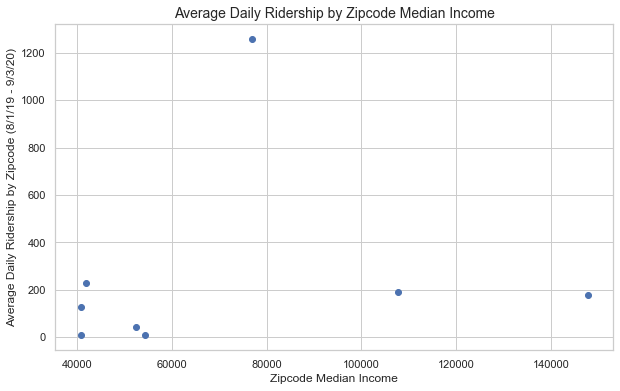

In [400]:
# Visualizing realtionship between average daily ridership and median income in a docking station's zip code
x = df.groupby(['citi_zipcode'])['Median'].median()
y = df.groupby(['citi_zipcode', 'date'])['rider'].sum().mean(level='citi_zipcode')

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x,y)
ax.set_title('Average Daily Ridership by Zipcode Median Income', fontsize = 14)
ax.set_xlabel('Zipcode Median Income')
ax.set_ylabel('Average Daily Ridership by Zipcode (8/1/19 - 9/3/20)')
plt.show()

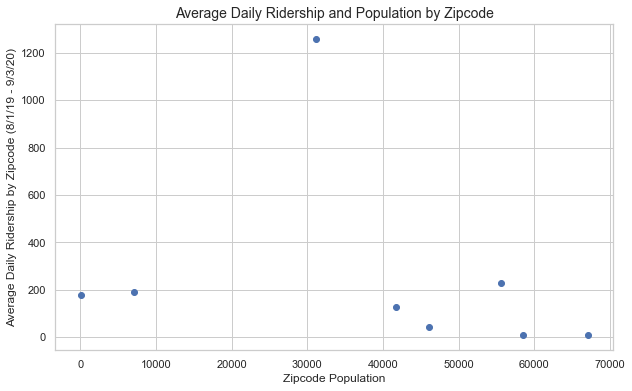

In [399]:
# Visualizing the relationship between average daily ridership and population
x = df.groupby(['citi_zipcode'])['Pop'].median()
y = df.groupby(['citi_zipcode', 'date'])['rider'].sum().mean(level='citi_zipcode')

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x,y)
ax.set_title('Average Daily Ridership and Population by Zipcode', fontsize = 14)
ax.set_xlabel('Zipcode Population')
ax.set_ylabel('Average Daily Ridership by Zipcode (8/1/19 - 9/3/20)')
plt.show()

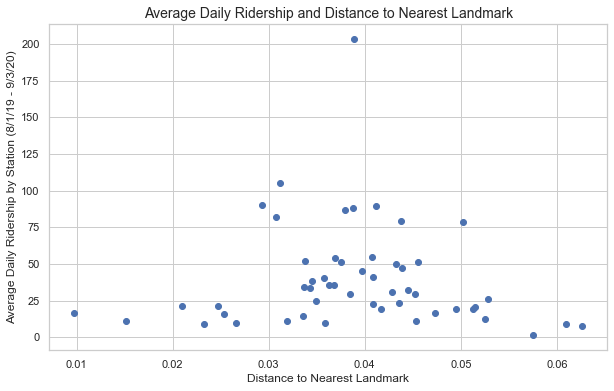

In [398]:
# Visualizing the relationship between distance to landmarks and average daily ridership
x = df.groupby(['station_id'])['dist_landmark'].median()
y = df.groupby(['station_id', 'date'])['rider'].sum().mean(level='station_id')

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x,y)
ax.set_title('Average Daily Ridership and Distance to Nearest Landmark', fontsize = 14)
ax.set_xlabel('Distance to Nearest Landmark')
ax.set_ylabel('Average Daily Ridership by Station (8/1/19 - 9/3/20)')
plt.show()

In [300]:
df = df[df['station_id']!=3475]

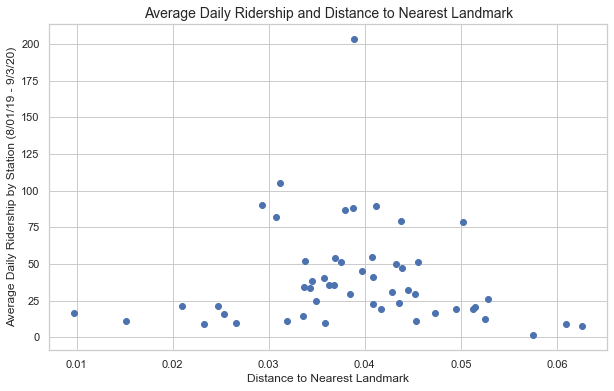

In [397]:
# Re-creating the visualization for relationship between distance to landmarks and average daily ridership
x = df.groupby(['station_id'])['dist_landmark'].median()
y = df.groupby(['station_id', 'date'])['rider'].sum().mean(level='station_id')

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(x,y)
ax.set_title('Average Daily Ridership and Distance to Nearest Landmark', fontsize = 14)
ax.set_xlabel('Distance to Nearest Landmark')
ax.set_ylabel('Average Daily Ridership by Station (8/01/19 - 9/3/20)')
plt.show()

[2073.5, 1987.7]


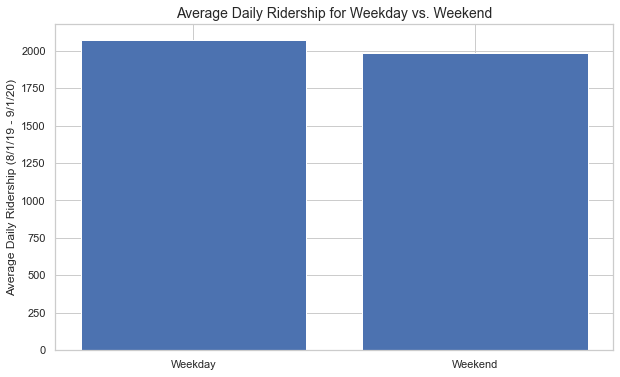

In [395]:
# Visualize Average Daily Ridership over the past year for weekdays vs. weekends
y = list(df.groupby(['weekend', 'date'])['rider'].sum().mean(level='weekend').apply(lambda x: round(x, 1)))
x = ['Weekday', 'Weekend']

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x,y)
ax.set_title('Average Daily Ridership for Weekday vs. Weekend', fontsize = 14)
ax.set_ylabel('Average Daily Ridership (8/1/19 - 9/1/20)')

print(y)
plt.show()

In [304]:
from scipy import stats

# Are these statistically different?
# H0: m1 = m2
# H1: m1 != m2
# 2 sample 2-tailed t-test 

t_stat, p_value = stats.ttest_ind(list(df.groupby(['weekend', 'date'])['rider'].sum().loc[0,:]),
               list(df.groupby(['weekend', 'date'])['rider'].sum().loc[1,:]))
print('t_stat: %.3f  p_value: %.3f'%(t_stat, p_value))

t_stat: 0.802  p_value: 0.423


In [305]:
df.groupby(['day', 'date'])['rider'].sum().mean(level='day').apply(lambda x: round(x, 1))

day
Friday       2094.0
Monday       1996.0
Saturday     2083.8
Sunday       1891.5
Thursday     2090.9
Tuesday      2092.6
Wednesday    2094.2
Name: rider, dtype: float64

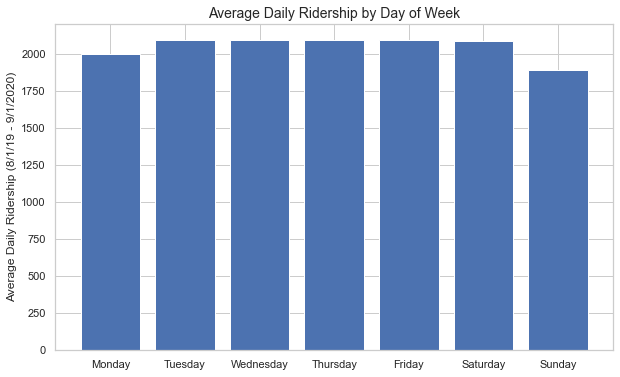

In [306]:
# Visualization for average daily ridership by day of the week
y = [1996.0, 2092.6, 2094.2, 2090.9, 2094.0, 2083.8, 1891.5]
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x,y)
ax.set_title('Average Daily Ridership by Day of Week', fontsize = 14)
ax.set_ylabel('Average Daily Ridership (8/1/19 - 9/1/2020)')

plt.show()

In [367]:
# Anova test to measure if these differnces are statistically significant
# H0: Ridership is the same every day of the week
# H1: Ridership is not the same every day of the week

from scipy.stats import f_oneway

Mon = list(df[df['day']=='Monday'].groupby('date')['rider'].sum())
Tues = list(df[df['day']=='Tuesday'].groupby('date')['rider'].sum())
Wed = list(df[df['day']=='Wednesday'].groupby('date')['rider'].sum())
Thurs = list(df[df['day']=='Thursday'].groupby('date')['rider'].sum())
Fri = list(df[df['day']=='Friday'].groupby('date')['rider'].sum())
Sat = list(df[df['day']=='Saturday'].groupby('date')['rider'].sum())
Sun = list(df[df['day']=='Sunday'].groupby('date')['rider'].sum())

F, p = f_oneway(Mon, Tues, Wed, Thurs, Fri, Sat, Sun)

print('F_stat: %.3f.   p-value: %.3f'%(F,p))

F_stat: 0.369.   p-value: 0.898


In [ ]:
# Given the very high p-value of 0.898, we cannot reject the null hypothesis that ridership differs by day of the
# week.

In [308]:
df.TAVG.isna().sum()

19062

In [285]:
df.groupby(['date']).TAVG.median()['2020-01-02']

40.0

In [256]:
df.TAVG = df.TAVG.apply(lambda x: 40.0 if (x==np.nan and df.date=='2020-01-01') else x)
df.TAVG = df.TAVG.apply(lambda x: 79.0 if (x==np.nan and df.date=='2020-07-29') else x)
df.TAVG = df.TAVG.apply(lambda x: 79.0 if (x==np.nan and df.date=='2020-07-30') else x)
df.TAVG = df.TAVG.apply(lambda x: 80.0 if (x==np.nan and df.date=='2020-07-31') else x)
df.TAVG = df.TAVG.apply(lambda x: 79.0 if (x==np.nan and df.date=='2020-08-01') else x)
df.TAVG = df.TAVG.apply(lambda x: 77.0 if (x==np.nan and df.date=='2020-08-02') else x)
df.TAVG = df.TAVG.apply(lambda x: 76.0 if (x==np.nan and df.date=='2020-08-03') else x)
df.TAVG = df.TAVG.apply(lambda x: 78.0 if (x==np.nan and df.date=='2020-08-04') else x)
df.TAVG = df.TAVG.apply(lambda x: 72.0 if (x==np.nan and df.date=='2020-09-01') else x)


In [309]:
df.TAVG.fillna(method='bfill', inplace=True)

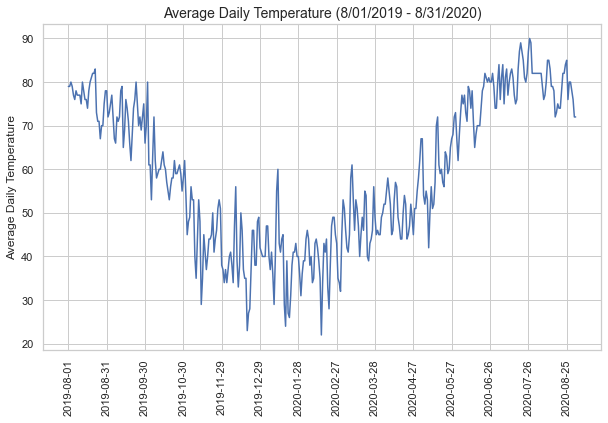

In [394]:
# Temperature over time
y = df.groupby(['date']).TAVG.median()
x = y.index

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y)
ax.set_title('Average Daily Temperature (8/01/2019 - 8/31/2020)', fontsize = 14)
ax.set_ylabel('Average Daily Temperature')
plt.xticks(np.arange(0,400,30), rotation=90)

plt.show()

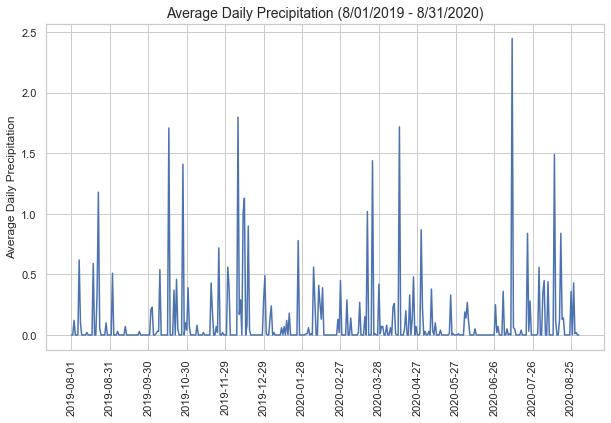

In [393]:
# Precipitation over time
y = df.groupby(['date']).PRCP.median()
x = y.index

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y)
ax.set_title('Average Daily Precipitation (8/01/2019 - 8/31/2020)', fontsize = 14)
ax.set_ylabel('Average Daily Precipitation')
plt.xticks(np.arange(0,400,30), rotation=90)

plt.show()

In [312]:
df.to_csv('citi_bike_nj_clean.csv')

In [313]:
df.head()

,date,station_id,tripduration,time,citi_station_name,citi_station_lat,citi_station_lon,citi_zipcode,PRCP,TAVG,dist_mta,train_name,train_lat,train_lon,landmark,landmark_lat,landmark_lon,dist_landmark,Median,Mean,Pop,rider,day,weekend
0,2019-08-01,3192,261.0,00:19:17.4780,Liberty Light Rail,40.711242,-74.055701,07302,0.0,79.0,0.022601,Journal Square,40.7327,-74.0628,Paulus Hook Park,40.758,-74.0374,0.050212,76967.05,98752.3753,31104.0,1,Thursday,0
1,2019-08-01,3186,172.0,00:25:59.1480,Grove St PATH,40.719586,-74.043117,07302,0.0,79.0,0.008522,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.038837,76967.05,98752.3753,31104.0,1,Thursday,0
2,2019-08-01,3203,525.0,00:32:13.7000,Hamilton Park,40.727596,-74.044247,07302,0.0,79.0,0.008459,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.031166,76967.05,98752.3753,31104.0,1,Thursday,0
3,2019-08-01,3185,219.0,00:36:15.2730,City Hall,40.717733,-74.043845,07302,0.0,79.0,0.010270,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.040780,76967.05,98752.3753,31104.0,1,Thursday,0
4,2019-08-01,3272,262.0,00:45:49.3530,Jersey & 3rd,40.723332,-74.045953,07302,0.0,79.0,0.009749,Newport Station,40.7247,-74.0363,Paulus Hook Park,40.758,-74.0374,0.035708,76967.05,98752.3753,31104.0,1,Thursday,0


In [314]:
df['month'] = df.date.apply(lambda x: x[5:7])

In [324]:
df.groupby(['date'])['rider'].sum()

date
2019-08-01    3627
2019-08-02    3555
2019-08-03    2912
2019-08-04    2385
2019-08-05    3437
2019-08-06    3489
2019-08-07    2387
2019-08-08    3432
2019-08-09    3351
2019-08-10    2902
2019-08-11    2678
2019-08-12    3440
2019-08-13    3215
2019-08-14    3394
2019-08-15    3512
2019-08-16    3616
2019-08-17    2584
2019-08-18    2195
2019-08-19    3115
2019-08-20    3546
2019-08-21    3225
2019-08-22    3217
2019-08-23    2903
2019-08-24    2952
2019-08-25    2714
2019-08-26    3207
2019-08-27    3392
2019-08-28    3169
2019-08-29    3621
2019-08-30    3379
2019-08-31    2453
2019-09-01    2357
2019-09-02    1480
2019-09-03    3550
2019-09-04    3766
2019-09-05    3689
2019-09-06    2473
2019-09-07    3156
2019-09-08    2447
2019-09-09    3482
2019-09-10    3461
2019-09-11    3811
2019-09-12    2928
2019-09-13    3653
2019-09-14    2826
2019-09-15    2937
2019-09-16    3370
2019-09-17    3624
2019-09-18    3600
2019-09-19    3683
2019-09-20    3589
2019-09-21    3788
2019-09

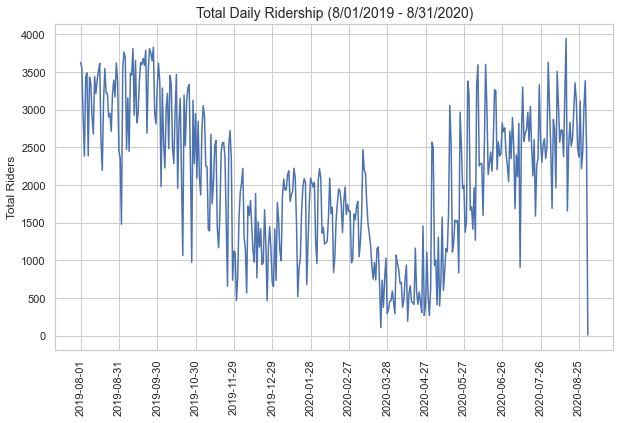

In [392]:
# Ridership by month
y = df.groupby(['date'])['rider'].sum()
x = y.index

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y)
ax.set_title('Total Daily Ridership (8/01/2019 - 8/31/2020)', fontsize = 14)
ax.set_ylabel('Total Riders')
plt.xticks(np.arange(0,400,30), rotation=90)

plt.show()

In [339]:
df_model = pd.read_csv('/Users/jmirabito/Desktop/Learn.co/mod_2_final_project/citibike_modeling_df.csv')

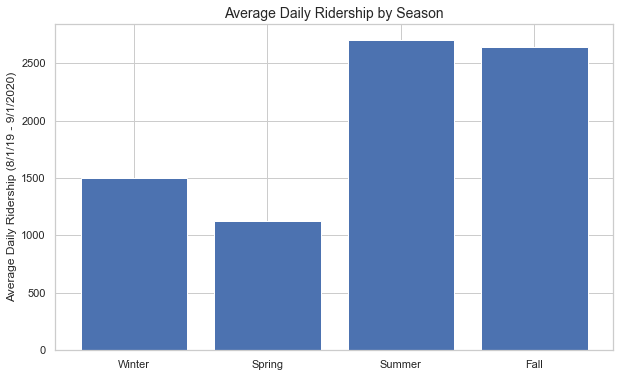

In [351]:
# Visualization for average daily ridership by season

y = [df_model.groupby(['date', 'winter'])['rider_count'].sum().mean(level='winter')[1],
df_model.groupby(['date', 'spring'])['rider_count'].sum().mean(level='spring')[1],
df_model.groupby(['date', 'summer'])['rider_count'].sum().mean(level='summer')[1],
df_model.groupby(['date', 'fall'])['rider_count'].sum().mean(level='fall')[1]]

x = ['Winter', 'Spring', 'Summer', 'Fall']

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x,y)
ax.set_title('Average Daily Ridership by Season', fontsize = 14)
ax.set_ylabel('Average Daily Ridership (8/1/19 - 9/1/2020)')

plt.show()

In [355]:
# Anova test to measure if these differnces are statistically significant
# H0: Ridership in all seasons is the same
# H1: Ridership in all seasons is not the same

from scipy.stats import f_oneway

a = list(df_model[df_model['winter']==1]['rider_count'])
b = list(df_model[df_model['spring']==1]['rider_count'])
c = list(df_model[df_model['summer']==1]['rider_count'])
d = list(df_model[df_model['fall']==1]['rider_count'])

F, p = f_oneway(a, b, c, d)

print('F_stat: %.3f.   p-value: %.3f'%(F,p))

F_stat: 557.860.   p-value: 0.000


In [ ]:
# Given the p-value of 0, we reject the null hypothesis and conclude that the differences in seasonal ridership
# are statistically significant. 

## Plot the relationships between each variable and daily ridership

In [372]:
df_model.head()

,date,station_id,rider_count,TAVG,PRCP,dist_PATH,dist_landmark,median_inc,mean_inc,population_zip,weekend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,07087,07302,07304,07305,07306,07307,07310,07311,fall,spring,summer,winter
0,2019-08-01,3184,86,79.0,0.0,0.010906,0.043861,76967.0500,98752.3753,31104.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,2019-08-01,3185,91,79.0,0.0,0.010270,0.040780,76967.0500,98752.3753,31104.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,2019-08-01,3186,501,79.0,0.0,0.008522,0.038837,76967.0500,98752.3753,31104.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,2019-08-01,3187,121,79.0,0.0,0.003982,0.036882,76967.0500,98752.3753,31104.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,2019-08-01,3191,22,79.0,0.0,0.025381,0.061002,40861.4099,56704.7387,41745.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [378]:
df_model.set_index(['date', 'station_id'], inplace=True)

In [381]:
df_model = df_model.astype(float)

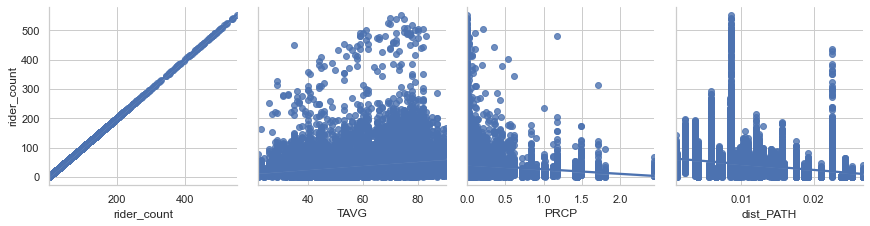

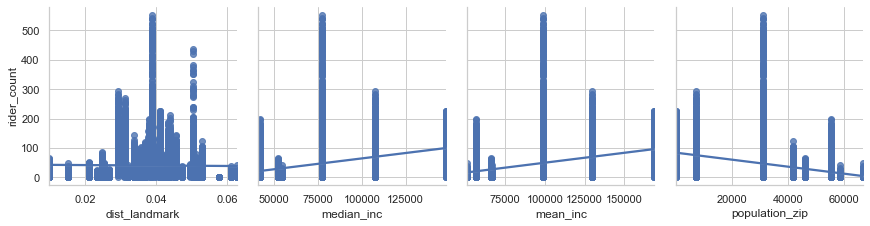

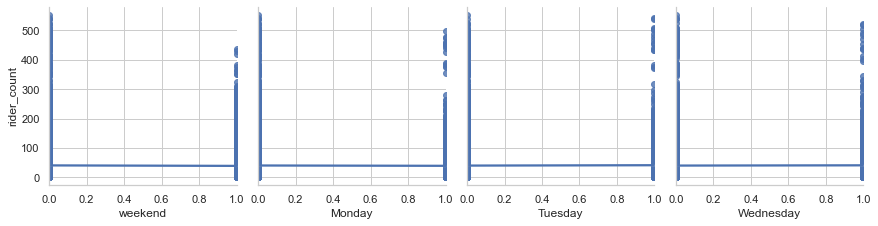

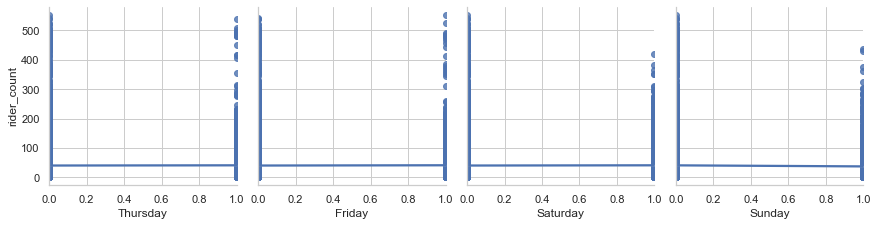

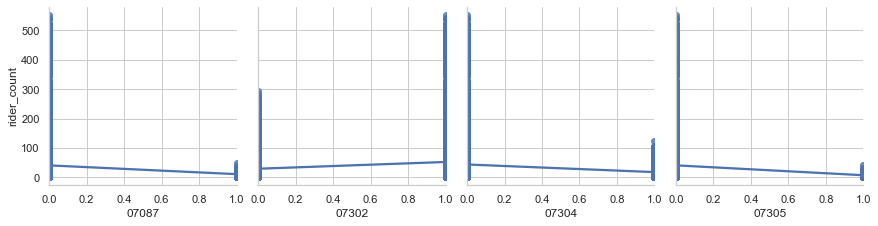

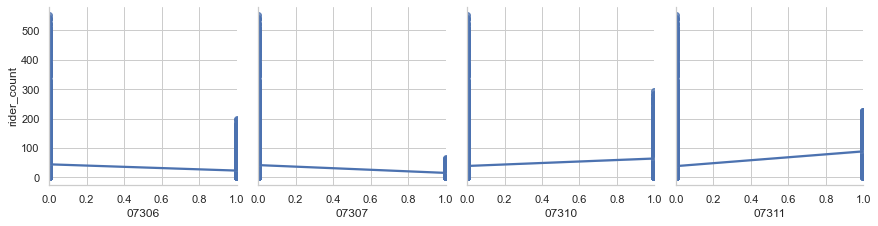

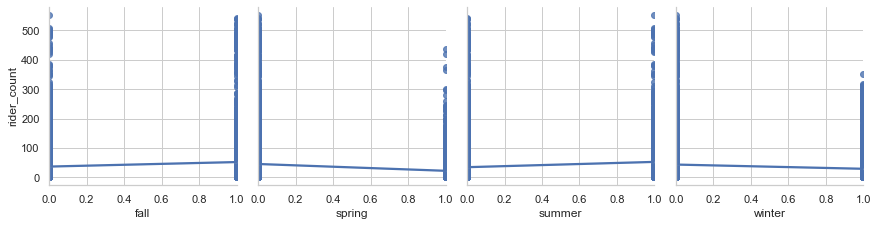

In [382]:
features = list(df_model.columns)

n = 4
row_groups= [features[i:i+n] for i in range(0, len(features), n)]

for i in row_groups:
    pp = sns.pairplot(data=df_model, y_vars=['rider_count'],x_vars=i, kind="reg", height=3)
plt.show()